**PROJET 8**
L'objectif de ce projet consiste à reprendre un projet précédent avec une méthode plus moderne afin d'en améliorer les résulats.

J'a choisi de reprendre le projet de classification des question à partir du jeu de données issu de Stack OverFlow.

Je vais mettre en oeuvre les éléments suivants :

*   Un premier traitement comme Baseline avec la librairie Keras de Tensorflow
*   Un traitement récent qui met en oeuvre des Transformers en utilisant la librairie T5



In [ ]:
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf

from sklearn.model_selection import train_test_split
from ast import literal_eval

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from nltk.tokenize import RegexpTokenizer
import nltk

Fonction de suppression des tags les moins utlisées (Reprise du projet pécédent)

In [ ]:
#Fonction qui supprime le tag si celui ci n'appartient au TOP        
def removeNotTop100(Word_list,Top100):
    filtered_Word_list = Word_list[:] #make a copy of the Word_list
    for Word in Word_list: # iterate over Word_list
        if Word not in Top100: 
            filtered_Word_list.remove(Word) # remove Word from filtered_Word_list if it is a stopword
    if len(filtered_Word_list) == 0:
        return None
    else:
        return filtered_Word_list

In [ ]:
# Google Drive connexion
from google.colab import drive
drive.mount('/content/drive')

#Lecture du Fichier
df = pd.read_csv('/content/drive/MyDrive/FORMATION/P8/QueryResultsFull.csv', sep = ',', encoding='UTF-8')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df.head(10)

,Id,BODY,Title,Tags,CreationDate
0,2293498,<p>I've written a Git post-commit hook and it ...,Applying a git post-commit hook to all current...,<git><hook><githooks>,2010-02-19 01:24:42
1,971123,<p>I need my footer to be fixed to the bottom ...,CSS: fixed to bottom and centered,<css><positioning><sticky-footer>,2009-06-09 16:24:58
2,12306,<p>I'm trying to serialize a Type object in th...,Can I serialize a C# Type object?,<c#><serialization>,2008-08-15 14:46:07
3,12492,<p>I use emacs to edit my xml files (nxml-mode...,Pretty printing XML files on Emacs,<xml><emacs><editor>,2008-08-15 17:17:14
4,12565,"<p>In Ruby, what's the difference between <cod...",What do the different brackets in Ruby mean?,<ruby><syntax>,2008-08-15 18:09:52
5,12592,<p>Is it possible to write a <code>doctest</co...,Can you check that an exception is thrown with...,<python><doctest>,2008-08-15 18:43:17
6,12633,<p>I'm trying to parse an INI file using C++. ...,What is the easiest way to parse an INI File i...,<c++><winapi><ini><fileparse>,2008-08-15 19:31:01
7,12647,<p>Is there a simple way in Perl that will all...,How do I tell if a variable has a numeric valu...,<perl><numbers>,2008-08-15 19:43:15
8,12661,<p>What's the most efficient way to resize lar...,Efficient JPEG Image Resizing in PHP,<php><image><gd><jpeg>,2008-08-15 19:55:17
9,12702,<p>I have a WCF service from which I want to r...,Returning DataTables in WCF/.NET,<c#><.net><wcf><web-services><datatable>,2008-08-15 20:26:01


Mise en majuscule et concaténation du champs Body et Title

In [ ]:
df["BODY"] = df["BODY"].str.lower()
df["Tags"] = df["Tags"].str.lower()
df["Title"] = df["Title"].str.lower()
df["TitleBody"] = df["Title"] + " " + df["BODY"]

Traitement du champs Tags. Ce champs contient les étiquettes de classification. Ce sont les éléments que nous voulons prédire.
Après traitement je supprime les lignes de mon Dataset avec des tags qui ne sont pas dans le TOP100

In [ ]:
#Expression régulière pour prendre uniquement les valeurs entre <>
tokenizer = RegexpTokenizer('(?<=\<).*?(?=\>)')

#Création de la colonne avec ces valeurs
df['tags_words'] = df.apply(lambda row: tokenizer.tokenize(row['Tags']), axis=1)

#Comptage de l'utlisation des mots
Top_Word = nltk.FreqDist()
Top100 = []
for x in df['tags_words']:
    Top_Word += nltk.FreqDist(x)

for i in Top_Word.most_common()[0:100]:
    Top100.append(i[0])
    
#Suppression des Tags qui ne sont pas dans le TOP
df['processed_tags_final'] = df.apply(lambda row:removeNotTop100(row['tags_words'],Top100), axis=1)

#Suppression des lignes sans Tags
df = df.dropna()

In [ ]:
df.shape

(44920, 8)

Création du jeu d'entrainement et de test

In [ ]:
test_split = 0.1

# Initial train and test split.
train_df, test_df = train_test_split(
    df,
    test_size=test_split
)

# Création des jeux de test et de validation
val_df = test_df.sample(frac=0.5)
test_df.drop(val_df.index, inplace=True)

print(f"Nombre d'enregistrement dans le jeu d'entrainement: {len(train_df)}")
print(f"Nombre d'enregistrement dans le jeu de validation: {len(val_df)}")
print(f"Nombre d'enregistrement dans le jeu de test: {len(test_df)}")

#Faire un découpage stratifié sur les étiquettes

Nombre d'enregistrement dans le jeu d'entrainement: 40428
Nombre d'enregistrement dans le jeu de validation: 2246
Nombre d'enregistrement dans le jeu de test: 2246


Préparation des étiquettes en utilisation le StringLookup de Keras.

**StringLookup** :
Va créer un vocabulaire à partir des étiquettes fournies
Ce vocabulaire va être trier par fréquences d'occurence

**Fonction invert_multi_hot :**
Fonction qui renvoie les étiquettes à partir d'une matrice binaire de prédiction

In [ ]:
terms = tf.ragged.constant(train_df["processed_tags_final"].values)
lookup = tf.keras.layers.StringLookup(output_mode="multi_hot")
lookup.adapt(terms)
vocab = lookup.get_vocabulary()

#Fonction qui va renvoyer les étiquettes à partir d'une liste encodée
def invert_multi_hot(encoded_labels):
    """Renvoi les étiquettes par rapport à un tableau de binaire."""
    hot_indices = np.argwhere(encoded_labels == 1.0)[..., 0]
    return np.take(vocab, hot_indices)


print("Vocabulaire:\n")
print(vocab)

Vocabulaire:

['[UNK]', 'python', 'javascript', 'java', 'c#', 'android', 'c++', '.net', 'html', 'php', 'jquery', 'css', 'git', 'ios', 'sql', 'string', 'c', 'mysql', 'sql-server', 'bash', 'arrays', 'linux', 'ruby', 'objective-c', 'node.js', 'ruby-on-rails', 'asp.net', 'iphone', 'django', 'windows', 'swift', 'regex', 'r', 'json', 'performance', 'asp.net-mvc', 'database', 'visual-studio', 'shell', 'list', 'reactjs', 'xcode', 'eclipse', 'wpf', 'angularjs', 'unit-testing', 'macos', 'algorithm', 'angular', 'multithreading', 'pandas', 'postgresql', 'vim', 'datetime', 'tsql', 'typescript', 'xml', 'spring', 'http', 'unix', 'linq', 'date', 'oop', 'github', 'file', 'docker', 'python-3.x', 'debugging', 'exception', 'dictionary', 'cocoa-touch', 'scala', 'c++11', 'generics', 'twitter-bootstrap', 'function', 'version-control', 'syntax', 'svn', 'numpy', 'language-agnostic', 'go', 'command-line', 'android-studio', 'class', 'security', 'dataframe', 'enums', 'ajax', 'sorting', 'math', 'intellij-idea', 'c

In [ ]:
#Exemple du résultat
sample_label = train_df["processed_tags_final"].iloc[0]
print(f"Etiquette d'origine: {sample_label}")

label_binarized = lookup([sample_label])
print(f"Représentation binaires des étiquettes: {label_binarized}")

Etiquette d'origine: ['angularjs']
Représentation binaires des étiquettes: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0.]]


Estimation de la longeur des Titres et corps de messages
On note que 50 % des résumés ont une longueur de 72. 

Maintenant, nous implémentons des utilitaires pour préparer nos jeux de données.

In [ ]:
train_df["TitleBody"].apply(lambda x: len(x.split(" "))).describe()

count    40428.000000
mean       131.303775
std        199.713972
min          8.000000
25%         52.000000
50%         85.000000
75%        145.000000
max       9056.000000
Name: TitleBody, dtype: float64

**Fonction pour préparer nos Dataset**

**make_dataset** :
Cette fonction va créer nos dataset avec les informations des étiquettes

In [ ]:
max_seqlen = 80
batch_size = 128
padding_token = "<pad>"
auto = tf.data.AUTOTUNE


def make_dataset(dataframe, is_train=True):
    labels = tf.ragged.constant(dataframe["processed_tags_final"].values)
    label_binarized = lookup(labels).numpy()
    dataset = tf.data.Dataset.from_tensor_slices(
        (dataframe["TitleBody"].values, label_binarized)
    )
    dataset = dataset.shuffle(batch_size * 10) if is_train else dataset
    return dataset.batch(batch_size)

**Création de nos Dataset**

In [ ]:
train_dataset = make_dataset(train_df, is_train=True)
validation_dataset = make_dataset(val_df, is_train=False)
test_dataset = make_dataset(test_df, is_train=False)

**Vérification de nos datasets**

In [ ]:
text_batch, label_batch = next(iter(train_dataset))

for i, text in enumerate(text_batch[:5]):
    label = label_batch[i].numpy()[None, ...]
    print(f"Abstract: {text}")
    print(f"Label(s): {invert_multi_hot(label[0])}")
    print(" ")

Abstract: b'what is the best way to seed a database in rails? <p>i have a rake task that populates some initial data in my rails app.  for example, countries, states, mobile carriers, etc.</p>\n\n<p>the way i have it set up now, is i have a bunch of create statements in files in /db/fixtures and a rake task that processes them.  for example, one model i have is themes.  i have a theme.rb file in /db/fixtures that looks like this:</p>\n\n<pre><code>theme.delete_all\ntheme.create(:id =&gt; 1, :name=&gt;\'lite\', :background_color=&gt;\'0xc7ffd5\', :title_text_color=&gt;\'0x222222\',\n                      :component_theme_color=&gt;\'0x001277\', :carrier_select_color=&gt;\'0x7683ff\', :label_text_color=&gt;\'0x000000\',\n                      :join_upper_gradient=&gt;\'0x6faeff\', :join_lower_gradient=&gt;\'0x000000\', :join_text_color=&gt;\'0xffffff\',\n                      :cancel_link_color=&gt;\'0x001277\', :border_color=&gt;\'0x888888\', :carrier_text_color=&gt;\'0x000000\', :publi

Comptage du nombre de mots unique dans notre texte du départ



In [ ]:
vocabulary = set()
train_df["TitleBody"].str.lower().str.split().apply(vocabulary.update)
vocabulary_size = len(vocabulary)
print(vocabulary_size)

443639



**Vectorisation**
Avant de fournir les données à notre modèle, nous devons les vectoriser (les représenter sous une forme numérique). 
Pour cela, nous utiliserons le TextVectorizationcalque.

Nous calculons d'abord le nombre de mots uniques présents dans les résumés.
Nous utilisons TF_IDF que j'ai déjà détaillé dans mon précédent projet

**TextVectorization :**


*   Taille du vocabulaire
*   Recombine les sous chaines chaines avec ngram
*   Utilisation de TF_IDF ou création d'un vecteur de taille 300
*   Mise en minuscule et suppression de la ponctuation





In [ ]:
#Pour le modèle simple
text_vectorizer = layers.TextVectorization(
    max_tokens=vocabulary_size, ngrams=2, output_mode="tf_idf",standardize = 'lower_and_strip_punctuation' 
)

#Pour le modèle Embedding
#text_vectorizer = layers.TextVectorization(
#    max_tokens=vocabulary_size, ngrams=2, output_mode="int",standardize = 'lower_and_strip_punctuation',output_sequence_length=300
#)


# `TextVectorization` layer needs to be adapted as per the vocabulary from our
# training set.
with tf.device("/CPU:0"):
    text_vectorizer.adapt(train_dataset.map(lambda text, label: text))

train_dataset = train_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)
validation_dataset = validation_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)
test_dataset = test_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)

**Création du modèle simple**

In [ ]:
def make_model():
    simple_mlp_model = keras.Sequential(
        [
            layers.Dense(512, activation="relu"),
            layers.Dense(256, activation="relu"),
            layers.Dense(lookup.vocabulary_size(), activation="sigmoid"),
        ]  
    )
    return simple_mlp_model

    #Ajouter une couche d'embeding (en limitant les nombres d'embedding)

    

Création du modèle avec une couche D'Embedding + LTSM

In [ ]:
from numpy import ma
embedding_dim = 128

def make_model_embedding():
    embedding_model = keras.Sequential(
        [
            layers.InputLayer(input_shape=(300, )),
            #layers.Input(shape=(None, ),dtype="int32"),
            layers.Embedding(vocabulary_size, embedding_dim),
            layers.LSTM(embedding_dim, activation= 'tanh',return_sequences=True),
            layers.Flatten(),
            layers.Dense(lookup.vocabulary_size(), activation="sigmoid"),
        ]
    )
    return embedding_model




In [ ]:
simple_mlp_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 300, 128)          56553472  
                                                                 
 lstm_5 (LSTM)               (None, 300, 128)          131584    
                                                                 
 flatten_5 (Flatten)         (None, 38400)             0         
                                                                 
 dense_5 (Dense)             (None, 101)               3878501   
                                                                 
Total params: 60,563,557
Trainable params: 60,563,557
Non-trainable params: 0
_________________________________________________________________


**Lancement du modèle**

Epoch 1/10
316/316 [==============================] - 35s 107ms/step - loss: 0.0598 - categorical_accuracy: 0.5431 - f1_metric: 0.5086 - val_loss: 0.0330 - val_categorical_accuracy: 0.6033 - val_f1_metric: 0.6509
Epoch 2/10
316/316 [==============================] - 33s 105ms/step - loss: 0.0064 - categorical_accuracy: 0.7273 - f1_metric: 0.9451 - val_loss: 0.0386 - val_categorical_accuracy: 0.6135 - val_f1_metric: 0.6741
Epoch 3/10
316/316 [==============================] - 33s 104ms/step - loss: 0.0021 - categorical_accuracy: 0.7560 - f1_metric: 0.9887 - val_loss: 0.0488 - val_categorical_accuracy: 0.6269 - val_f1_metric: 0.6623
Epoch 4/10
316/316 [==============================] - 34s 105ms/step - loss: 0.0018 - categorical_accuracy: 0.7681 - f1_metric: 0.9924 - val_loss: 0.0498 - val_categorical_accuracy: 0.6247 - val_f1_metric: 0.6614
Epoch 5/10
316/316 [==============================] - 33s 105ms/step - loss: 0.0019 - categorical_accuracy: 0.7873 - f1_metric: 0.9916 - val_loss: 0

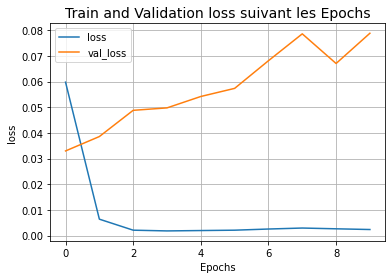

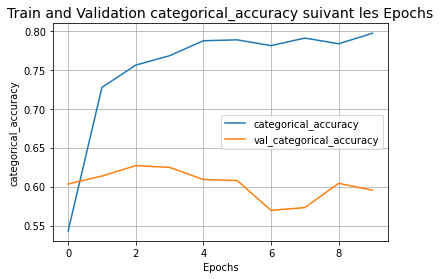

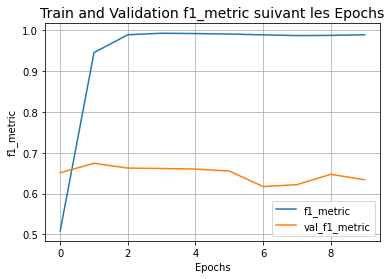

In [ ]:
epochs = 10

#Metrics
#NumClass : Nombre possible d'étiquette en sortie

simple_mlp_model = make_model()
simple_mlp_model.compile(
    loss="binary_crossentropy", optimizer="adam", metrics=["categorical_accuracy",f1_metric]
)

history = simple_mlp_model.fit(
    train_dataset, validation_data=validation_dataset, epochs=epochs
)


def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} suivant les Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_result("loss")
plot_result("categorical_accuracy")
plot_result("f1_metric")

In [ ]:
#Fonction de calcul du F1_Score
from tensorflow.keras import backend as K
def f1_metric(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [ ]:
test_dataset = make_dataset(test_df, is_train=False)
test_dataset = test_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)

**Evaluation du modèle**

Le modèle entraîné nous donne une précision d'évaluation d'environ 60 %.

In [ ]:
_, categorical_acc,f1_score = simple_mlp_model.evaluate(test_dataset)
print(f"Accuracy sur le jeu de test: {round(categorical_acc * 100, 2)}%.")

18/18 [==============================] - 2s 81ms/step - loss: 0.0833 - categorical_accuracy: 0.5882 - f1_metric: 0.6344
Accuracy sur le jeu de test: 58.82%.


In [ ]:
from sklearn.metrics import (
    accuracy_score, 
    f1_score, 
    classification_report
)
aff = 0
etiquette_reelle = []
prediction = []
# Création du modèle
model_for_inference = keras.Sequential([text_vectorizer, simple_mlp_model])

# Création d'un petit jeu de données afin d'en faire la démonstration
inference_dataset = make_dataset(test_df, is_train=True)
text_batch, label_batch = next(iter(inference_dataset))
predicted_probabilities = model_for_inference.predict(text_batch)

# Calcul de la prédiction.
for i, text in enumerate(text_batch):
    label = label_batch[i].numpy()[None, ...]
    if aff < 5 :
      print(f"Text: {text}")
      print(f"Etiquette(s) réelles: {invert_multi_hot(label[0])}")
    predicted_proba = [proba for proba in predicted_probabilities[i]]
    top_3_labels = [
        x
        for _, x in sorted(
            zip(predicted_probabilities[i], lookup.get_vocabulary()),
            key=lambda pair: pair[0],
            reverse=True,
        )
    ][:1]

    etiquette_reelle.append(label[0])
    prediction.append(np.array(lookup([top_3_labels])[0]))

    if aff < 5 :
      print(aff)
      print(f"Predicted Label(s): ({', '.join([label for label in top_3_labels])})")
      print(" ")
      aff=aff+1

#Calcul de la prédiction avec Sklearn pour la comparer avec T5
print("Accuracy",accuracy_score(etiquette_reelle, prediction))
print("F1_Score", f1_score(etiquette_reelle, prediction, average='micro'))

Text: b'python list subtraction operation <p>i want to do something similar to this:</p>\n\n<pre><code>&gt;&gt;&gt; x = [1,2,3,4,5,6,7,8,9,0]  \n&gt;&gt;&gt; x  \n[1, 2, 3, 4, 5, 6, 7, 8, 9, 0]  \n&gt;&gt;&gt; y = [1,3,5,7,9]  \n&gt;&gt;&gt; y  \n[1, 3, 5, 7, 9]  \n&gt;&gt;&gt; y - x   # (should return [2,4,6,8,0])\n</code></pre>\n\n<p>but this is not supported by python lists\nwhat is the best way of doing it?</p>\n'
Etiquette(s) réelles: ['python' 'list']
0
Predicted Label(s): (python)
 
Text: b'how to get application object into fragment class <p>i am changing my android mobile app to support both tablets and mobile phone. for this i am changing my activity class into fragment. in my activity class i have an instance of my application class created as below:</p>\n\n<pre><code>appctx = (unitymobileapp) getapplication();\n</code></pre>\n\n<p>where <code>unitymobileapp</code> is my application class.</p>\n\n<p>now i want to create the same instance in my fragment class. can you guys pl